# Logistic regression - a simple classification algorithm

## Information collection
* Blog post explaining logreg from scratch in short: https://beckernick.github.io/logistic-regression-from-scratch/
* Github repo jupyter-notebook logreg from scratch: https://github.com/beckernick/logistic_regression_from_scratch/blob/master/logistic_regression_scratch.ipynb
* ayoai intro mashine learning and logreg: https://ayearofai.com/rohan-1-when-would-i-even-use-a-quadratic-equation-in-the-real-world-13f379edab3b#.986r1m90h
* ayoai deep dive in logreg: https://ayearofai.com/rohan-6-follow-up-statistical-interpretation-of-logistic-regression-e78de3b4d938

## follow Nick Beckers (NVIDIA) LogReg from scratch

In [2]:
# load the standard tools

#import numpy as np
#import matplotlib.pyplot as plt
#%matplotlib inline

# this is equivalent to the above lines
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


### The data matters

To understand why this is useful, we can assume the data to be of some importance. In ML very frequently the classification of a tumor to be dangerous or not is used as an example. In our simple case, the two feature values (x,y) may be two measured parameters of a tumor and the labels $[0,1]$ might be dangerous and not dangerous.

In [31]:
# create data sets using random data -> data sets for different classes should be distinguishable

# fix the seed for reproduction
np.random.seed(12)

# define the number of points that belong to a single set
num_observations = 5000
#num_observations = 50

# fist set is the data of class "1 - true" normally distributed around (0,0) ...
x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
# ##  numpy.random.multivariate_normal(mean, cov[, size, check_valid, tol])
# ## mean : 1-D array_like, of length N: Mean of the N-dimensional distribution.
# ## cov : 2-D array_like, of shape (N, N): Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.

# ... that cane be distinguished from the data in second set belonging to class "0 -false"
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

In [32]:
# merge the data in compact numpy arrays

# stack the data in 'points -> class' arrays
# simulated_separableish_features[i] --has label--> simulated_labels[i]
simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))

<IPython.core.display.Javascript object>


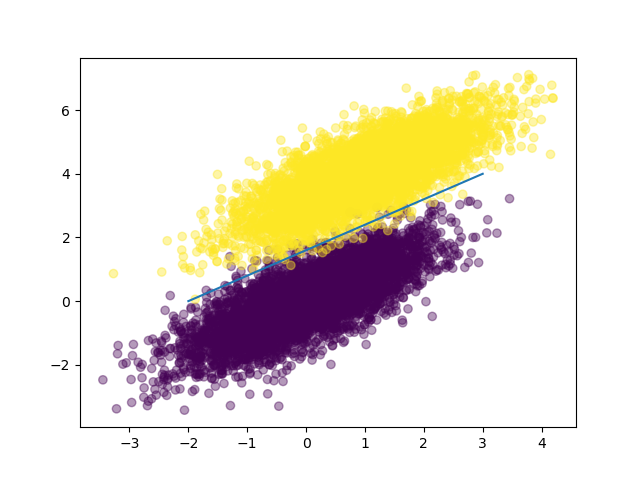

In [33]:
# plot the data and check if it is separable
figure()

scatter(simulated_separableish_features[:, 0],# x values of all points
        simulated_separableish_features[:, 1],# y values of all points
        c = simulated_labels,# colors map using the classes [1,0]
        alpha = .4 #transparancy in case theres are overlapping points
       )
# ## matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=None, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)
# ## x, y : array_like, shape (n, ): The data positions.
# ## c : color, sequence, or sequence of color, optional: The marker color. Possible values: A single color format string. A sequence of color specifications of length n. A sequence of n numbers to be mapped to colors using cmap and norm. A 2-D array in which the rows are RGB or RGBA.
# ## alpha : scalar, optional, default: None: The alpha blending value, between 0 (transparent) and 1 (opaque).

# classification should divide data sets (here line drawn guided by the eyes)
# -> the maschine learning algorithm determines the best parameteres for this "line"
plot([-2,3],[0,4])

show()

## Idea of the algorithm
* find a function that classifies data $x$ according to the trainings data ($X$ data, $y$ classes)
* use a **hypothesis function** $h(x,\Theta)$ with a corresponding **parameter vector** $\Theta$
* the parameter vector are the so called **weights** that are optimized to fit the trainings data best $h(X,\Theta) \approx y$

For classififcation the **sigmoid function** is often used as hypothesis function/link function:

> $h(x,\Theta) = \dfrac{1}{1+e^{-\Theta^{T} x}}$

In [19]:
# define general sigmoid function
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

## optimization by cost function and gradient ascent method

* chosing a cost function that evaluates the accuracy of the current set of weights (vector $\Theta$)
* calculating the derrivative of the cost function
* change the weights by the scaled value of the gradient using a learning rate $\alpha$

Using likelyhood maximization, the cost function is the likelyhood and must be maximized.
For logistic regression the log-likelyhood ($ll$) is used most commonly because the log transformation is monotonic for binary classifications making the equations pretty simple ( details in [The Elements of
Statistical Learning](https://web.stanford.edu/~hastie/ElemStatLearn//) )

> $ll = \sum_{i=1}^{N} \left[ y_i \Theta^T x_i - \ln \left( 1+ e^{\Theta^T x_i} \right) \right]$

In [21]:
def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    return np.sum( target*scores - np.log(1 + np.exp(scores)) )

The gradient of the log-likelyhood is given by

> $\nabla ll = X^T (Y - Y_p)$

where $Y_p$ are the current predictions $h(x,\Theta)$ with the current weigths $\Theta$.

In [24]:
def grad_log_likelyhood(features, weights, target):
    output_error_signal = target - sigmoid(np.dot(features, weights))
    return np.dot(features.T, output_error_signal)

Now, the weights are updated using the learning rate $\alpha$

> $\Theta := \Theta + \alpha \nabla ll $

which is simply done in line. This procedure converges because the log-likelyhood is a strictly concave function.

### Bias term

Most functions have a constant term added that is not attached to any feature. This incerease the weight vector by one and is therefore often denoted $\Theta_0$.

$h(x,\Theta_0,\Theta)= \text{const}(\Theta_0) +\dfrac{1}{1+e^{-\Theta^{T} x}} = \dfrac{1}{1+e^{\Theta_0}} + \dfrac{1}{1+e^{-\Theta^{T} x}} $

To correctly calculate the hypothesis function with the constant $\Theta_0$, we simply add a $1$ as first component to every feature.

Summing up the above procedure of **optimizing the weights = training** yields the following function:

In [45]:
def logistic_regression(features, target, num_steps, learning_rate):
    # here the bais term is added 
    intercept = np.ones((features.shape[0], 1))
    features = np.hstack((intercept, features))
        
    # initialize weights (0=\Theta_0, 0=\Theta_1, 0=\Theta_2)
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        # calculate actual gradient
        gradient = grad_log_likelyhood(features, weights, target)
        # update the weights
        weights += learning_rate * gradient
        
        # Print log-likelihood every so often -> should increase monotonically
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

### Run the model and get results for the perfect parameters

In [46]:
num_steps = 300000
learning_rate = 5e-5
weights = logistic_regression(simulated_separableish_features, simulated_labels,
                     num_steps, learning_rate)
print(weights)

-4346.264779152365
-148.70672276805348
-142.96493623107838
-141.54530307157367
-141.060319659308
-140.87031585891606
-140.79025912753815
-140.75505002269912
-140.73914503180953
-140.73183498915878
-140.72843666694826
-140.72684471255332
-140.72609508950467
-140.725740860523
-140.72557306887177
-140.72549345786166
-140.72545564250743
-140.7254376661433
-140.72542911609153
-140.7254250479478
-140.72542311181698
-140.72542219020235
-140.72542175145267
-140.72542154256132
-140.72542144310114
-140.72542139574284
-140.72542137319252
-140.72542136245454
-140.7254213573414
-140.72542135490647
[-14.09225541  -5.05899648   8.28955762]


### Comparsion to available ML library [scikit-learn](https://towardsdatascience.com/an-introduction-to-scikit-learn-the-gold-standard-of-python-machine-learning-e2b9238a98ab)

In [47]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(fit_intercept=True, C = 1e15) # C = 1e15 basically turns of an optimzation to be comparable to our function
clf.fit(simulated_separableish_features, simulated_labels)

print(clf.intercept_, clf.coef_)
print(weights)

[-13.99400797] [[-5.02712572  8.23286799]]
[-14.09225541  -5.05899648   8.28955762]


* basically same results -> our function will approach these values as well (by adjusting learning rate and number of iterations)
* orders of magnitude faster -> highly optimized solver
* two lines of code

$\Rightarrow$ if possible, **use these optimzed libraries** to not waste ressources

## What about accuracy?

The numeric value of the cost function is often not very meaningful. For binary classification the accuracy is calculated by counting the number of correct predictions with respect tot the total number of predictions.

In [40]:
data_with_intercept = np.hstack((np.ones((simulated_separableish_features.shape[0], 1)),
                                 simulated_separableish_features))
final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy from scratch: {}'.format((preds == simulated_labels).sum().astype(float) / len(preds)) )
print('Accuracy from sk-learn: {}'.format(clf.score(simulated_separableish_features, simulated_labels)))


Accuracy from scratch: 0.9948
Accuracy from sk-learn: 0.9948


## What does the result look like?

Since there seems to be an error of about $0.5\%$, these counts should be located at the overlap of the data that is not separable.

<IPython.core.display.Javascript object>


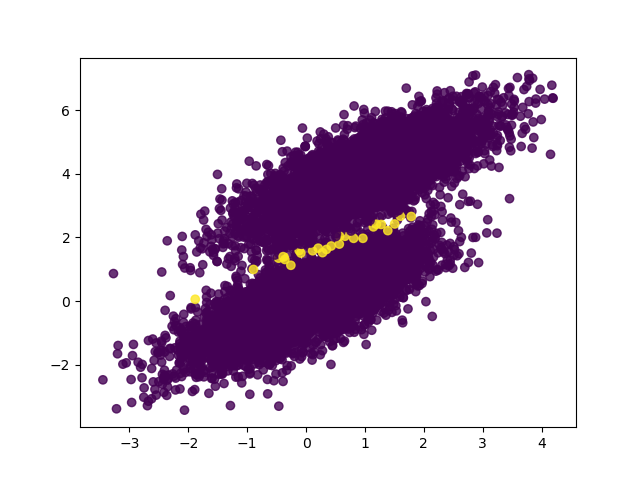

In [44]:
figure()
scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = preds == simulated_labels - 1, alpha = .8)#, s = 30)
show()

# Beyond binary classification

The logistic regression using the sigmoid function is useful but limited to rather simple problems with fully **separable data**.
Adding more features would only increase the size of the weigth vector which is fine.
But adding more classes is just not possible.

The way out are networks with a linear combination of nodes performing a single decision - for instance using the sigmoid function, or also popular the **relu** function - that have more than one output node at the end.

By adding a third point cloud to the data above (for instance a not dangerous cancer type that however should be removed) is becomes neccessary to use a (neuronal) network of nodes:

<IPython.core.display.Javascript object>


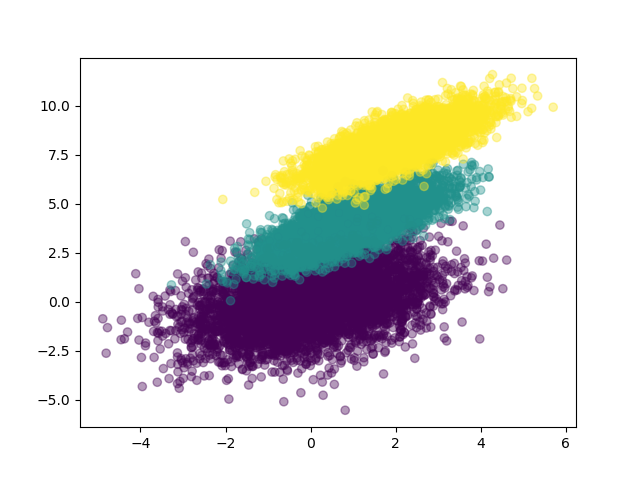

In [58]:
np.random.seed(12)
num_observations = 5000

x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[1, .75],[.75, 1]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((
    np.zeros(num_observations),
    np.ones(num_observations), 
    np.ones(num_observations) + 1
))

figure()
scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
show()

In [59]:
########################################################
#    THIS REQUIRES TENSORFLOW TO BE INSTALLED          #
########################################################

# How does it look like using tensorflow?
import tensorflow as tf
from sklearn.model_selection import train_test_split

########################################################################################
# again setup the simulated data
np.random.seed(12)
num_observations = 5000
x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[1, .75],[.75, 1]], num_observations)
simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((
    np.zeros(num_observations),
    np.ones(num_observations), 
    np.ones(num_observations) + 1
))

# tensorflow expects one-hot encoded labels ( 1000, 0100, 0010, ...)
labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1

# split data set into training and test set
train_dataset, test_dataset, train_labels, test_labels = train_test_split(
    simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12)

########################################################################################
# setup model parameters
hidden_nodes = 5
num_labels = train_labels.shape[1]
batch_size = 100
num_features = train_dataset.shape[1]
learning_rate = .01

# build up the graph = the network
graph = tf.Graph()
with graph.as_default():
    
    # Data
    tf_train_dataset = tf.placeholder(tf.float32, shape = [None, num_features])
    tf_train_labels = tf.placeholder(tf.float32, shape = [None, num_labels])
    tf_test_dataset = tf.constant(test_dataset)
  
    # Weights and Biases
    layer1_weights = tf.Variable(tf.truncated_normal([num_features, hidden_nodes]))
    layer1_biases = tf.Variable(tf.zeros([hidden_nodes]))
    
    layer2_weights = tf.Variable(tf.truncated_normal([hidden_nodes, num_labels]))
    layer2_biases = tf.Variable(tf.zeros([num_labels]))
    
    # Three-Layer Network
    def three_layer_network(data):
        input_layer = tf.matmul(data, layer1_weights)
        hidden = tf.nn.relu(input_layer + layer1_biases)
        output_layer = tf.matmul(hidden, layer2_weights) + layer2_biases
        return output_layer
    
    # Model Scores
    model_scores = three_layer_network(tf_train_dataset)
    
    # Loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model_scores, tf_train_labels))
  
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
    # Predictions
    train_prediction = tf.nn.softmax(model_scores)
    test_prediction = tf.nn.softmax(three_layer_network(tf_test_dataset))
    
# define an accuracy function that takes one-hot encoded labels
def accuracy(predictions, labels):
    preds_correct_boolean =  np.argmax(predictions, 1) == np.argmax(labels, 1)
    correct_predictions = np.sum(preds_correct_boolean)
    accuracy = 100.0 * correct_predictions / predictions.shape[0]
    return accuracy

# last setup - how many steps to iterate:
num_steps = 10001

########################################################################################
# now run the graph in batches with the training data and the test data 
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        minibatch_data = train_dataset[offset:(offset + batch_size), :]
        minibatch_labels = train_labels[offset:(offset + batch_size)]
        
        feed_dict = {tf_train_dataset : minibatch_data, tf_train_labels : minibatch_labels}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict = feed_dict
            )
        
        if step % 1000 == 0:
            print 'Minibatch loss at step {0}: {1}'.format(step, l)

    print 'Test accuracy: {0}%'.format(accuracy(test_prediction.eval(), test_labels))
    
# now it is done, the weights can be used to classify unknown data

ModuleNotFoundError: No module named 'tensorflow'

## Building a Neural Network from Scratch

For a neural network, we need:

* A model architecture
* Arrays of weight vectors
* Arrays of bias vectors
* An activation function
* A function to convert the output to a probability distribution
* A loss function
* A way to use the output of the model to tune the model iteratively and improve it (error backpropagation)